## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 
from scipy.stats import norm, linregress
#from gpyrn import covfunc, meanfunc, meanfield
import exoplanet as xo
from scipy.optimize import minimize
from scipy.stats import norm
import csv
from scipy import stats
from multiprocessing import Pool
import emcee
import corner
from loguniform import LogUniform, ModifiedLogUniform
import sys
sys.path.append(os.path.abspath("/home/paul/Bureau/IRAP/TediGP"))
import process, kernels, means
from scipy import signal
from tqdm import tqdm

np.random.seed(110*110)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load 2 first componant

In [2]:
eigen2vectors = np.load('/home/paul/Bureau/IRAP/TablesAU_MIC/2firstcomponent.npy', allow_pickle=True)
times = np.load('/home/paul/Bureau/IRAP/TablesAU_MIC/readyforwPCA_epoc.npy')

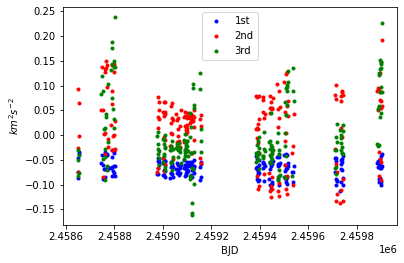

In [3]:
plt.plot(times[:-1], eigen2vectors[0], 'b.', label='1st')
plt.plot(times[:-1], eigen2vectors[1], 'r.', label='2nd')
plt.plot(times[:-1], eigen2vectors[2], 'g.', label='3rd')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
#plt.plot(times[:-1], eigen2vectors[3], 'r.')

plt.show()

## Periodograms
### 1st component

Peak frequency = 
4.872250163692226


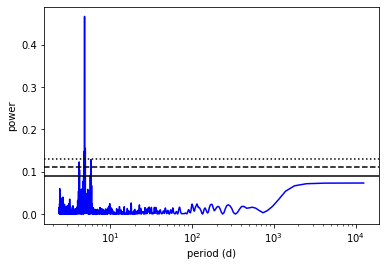

In [17]:
frequency, power = LombScargle(times[:-1], eigen2vectors[0]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'b')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times[:-1], eigen2vectors[0])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### 2nd component

Peak frequency = 
4.872250163692226


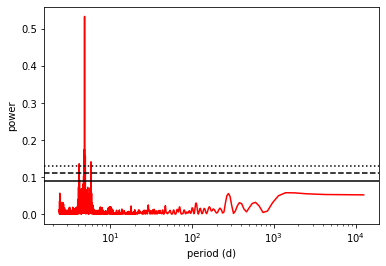

In [18]:
frequency, power = LombScargle(times[:-1], eigen2vectors[1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times[:-1], eigen2vectors[1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### 3rd component

Peak frequency = 
359.01523349035


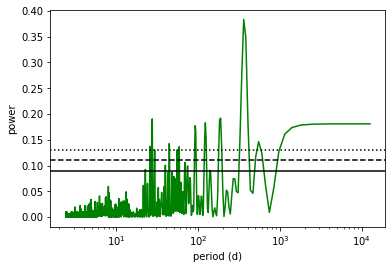

In [19]:
frequency, power = LombScargle(times[:-1], eigen2vectors[2]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'g')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times[:-1], eigen2vectors[2])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

## First component GP

Just to recall the GP uses a Quasi-Periodic covariance function that is build that way:


$K_{ij} = \eta_1^2 \, \exp \left[- \frac{(t_i - t_j)^2}{2 \eta_2^2} - \frac{2 }{\eta_4^2} \sin^2 \left( \frac{\pi (t_i - t_j)}{\eta_3} \right) \right] + Jitter$ 

In [20]:
print(2*(np.max(eigen2vectors[0])- np.min(eigen2vectors[0])))
print(np.std(eigen2vectors[0]))
print(10*(np.max(times[:-1])-np.min(times[:-1])))


0.1668876987460044
0.016793872222717703
12565.53317216225


For the Prior distribution, I use : 

$\eta_1 : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

$\eta_2 : \mathcal{LU}\left( 1 , 10 \times t_{total} \right)$

$\eta_3 : \mathcal{N}\left( P , 0.1 \right)$

$\eta_4 : \mathcal{MLU}\left( 0.1, 5 \right)$

$Jitter : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

In [21]:
#Priors
n_eta1 = ModifiedLogUniform(0.016, 0.16)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.016, 0.16)

In [22]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [23]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[0], yerr = 1e-12 * np.identity(times[:-1].size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [24]:
ndim = priors().size 
nwalkers = 2*ndim

In [25]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [06:53<00:00, 24.20it/s]


State([[2.17478337e-02 1.38767966e+02 4.85956724e+00 9.20755628e-01
  4.38584446e-03]
 [1.91795174e-02 1.64668042e+02 4.85860900e+00 1.11987478e+00
  4.48295112e-03]
 [1.47738181e-02 1.27522037e+02 4.85924909e+00 8.25353578e-01
  4.63182794e-03]
 [2.14722040e-02 2.09052081e+02 4.85702968e+00 1.05929085e+00
  5.06624589e-03]
 [1.60005792e-02 2.67891164e+02 4.86619958e+00 8.43830660e-01
  4.98754482e-03]
 [1.97051612e-02 1.51946036e+02 4.85707815e+00 1.01996851e+00
  4.20320367e-03]
 [1.78431429e-02 2.08416647e+02 4.86182967e+00 6.99129756e-01
  4.24674576e-03]
 [1.64063404e-02 1.32418792e+02 4.84818130e+00 6.24184145e-01
  4.44275935e-03]
 [2.17507518e-02 1.53508757e+02 4.86174329e+00 9.84030960e-01
  4.14431462e-03]
 [1.75442830e-02 1.11800947e+02 4.85324975e+00 7.94795267e-01
  4.33267001e-03]], log_prob=[742.49769658 739.44647079 743.959045   736.61246679 737.68983553
 740.87565914 739.50967678 739.84016743 741.40096968 742.5157462 ], blobs=None, random_state=('MT19937', array([16756

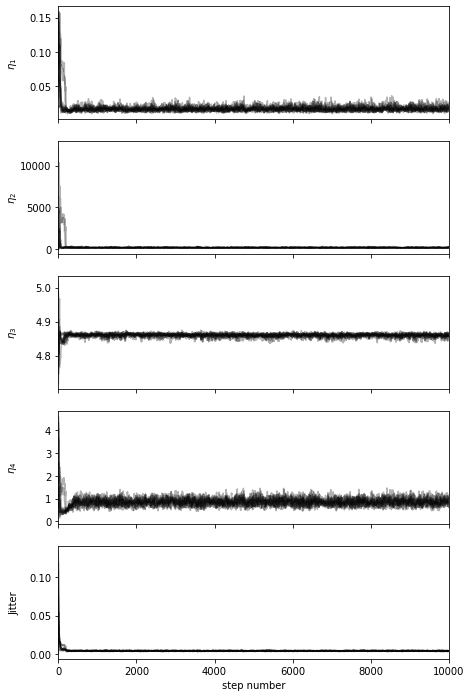

In [26]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

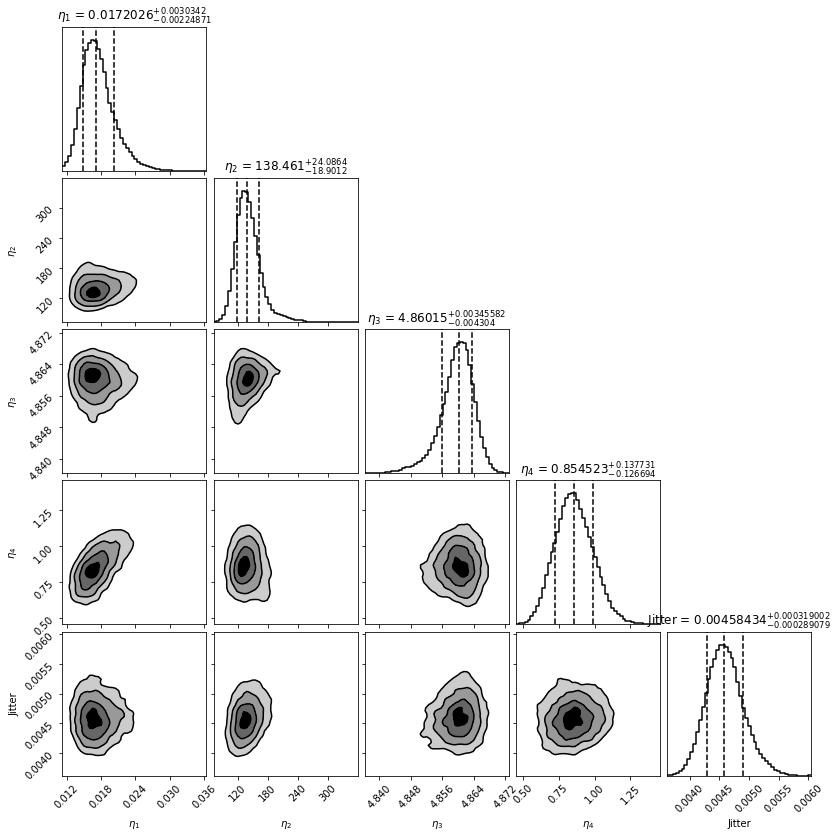

In [27]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

In [28]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[0],yerr = 1e-12 * np.identity(times[:-1].size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

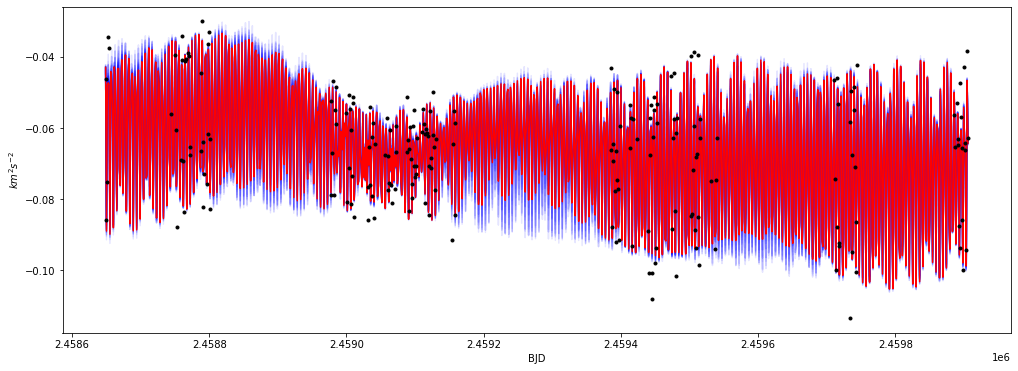

In [29]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times[:-1]), np.max(times[:-1]), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.plot(times[:-1], eigen2vectors[0],'k.')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

100%|██████████| 15/15 [01:34<00:00,  6.29s/it]


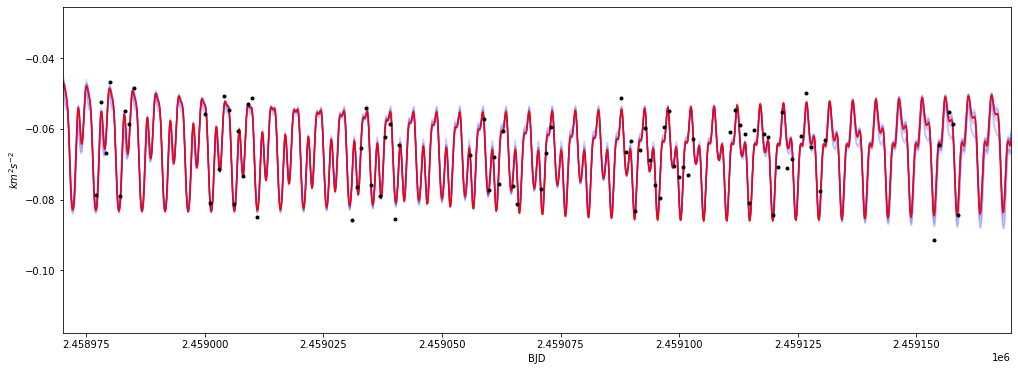

In [30]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times[:-1]), np.max(times[:-1]), 10000)

for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.plot(times[:-1], eigen2vectors[0],'k.')
plt.xlim([-30+2459000, 170+2459000])
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

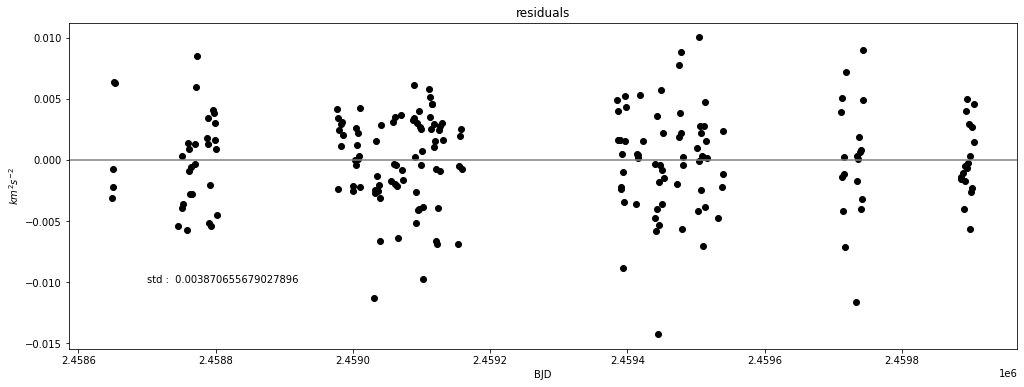

In [31]:
y_sample = Display(Hfit, times[:-1])

residuals = eigen2vectors[0] - y_sample
plt.figure(figsize=(17, 6))
plt.plot(times[:-1], residuals, 'ok')
plt.axhline(y=0, c='grey')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, -0.01) )
plt.title('residuals')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

## 2nd component GP

In [32]:
print(2*(np.max(eigen2vectors[1])- np.min(eigen2vectors[1])))
print(np.std(eigen2vectors[1]))
print(10*(np.max(times[:-1])-np.min(times[:-1])))

0.6569246234698661
0.06718304428248568
12565.53317216225


In [33]:
#Priors
n_eta1 = ModifiedLogUniform(0.06, 0.65)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.06, 0.65)

In [34]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [35]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[1]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[1], yerr = 1e-12 * np.identity(times[:-1].size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [36]:
ndim = priors().size 
nwalkers = 2*ndim

In [42]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [07:02<00:00, 23.68it/s]


State([[7.39073815e-02 1.50513483e+02 4.86011755e+00 9.74220667e-01
  9.49209002e-03]
 [5.48312190e-02 1.39353788e+02 4.85905498e+00 7.42321283e-01
  8.59230797e-03]
 [6.88201115e-02 1.34895973e+02 4.86245684e+00 8.89905276e-01
  9.65449023e-03]
 [6.50957022e-02 1.37802154e+02 4.86237205e+00 8.96319394e-01
  9.12367028e-03]
 [8.61697999e-02 1.50495295e+02 4.86497251e+00 8.73391914e-01
  9.22290142e-03]
 [6.57855974e-02 1.25417896e+02 4.85743768e+00 8.55033979e-01
  8.22371330e-03]
 [8.35635053e-02 1.58055511e+02 4.85808634e+00 8.45919270e-01
  9.33070443e-03]
 [5.39648651e-02 1.32192042e+02 4.86305711e+00 8.95819310e-01
  8.61667631e-03]
 [8.40876668e-02 1.58627680e+02 4.86184540e+00 9.10305237e-01
  1.01422686e-02]
 [6.33557161e-02 1.50274778e+02 4.86404614e+00 8.58715056e-01
  8.14548052e-03]], log_prob=[550.32228504 549.28745265 551.07832123 551.35143203 547.08526069
 549.11091959 547.76437451 547.52790323 548.61772407 546.94075815], blobs=None, random_state=('MT19937', array([16756

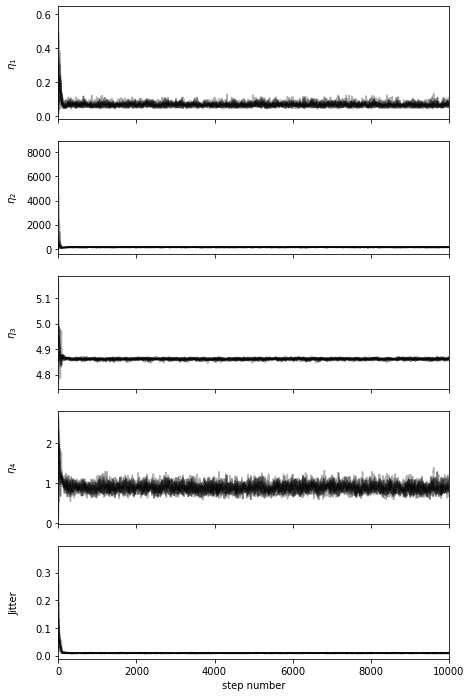

In [43]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

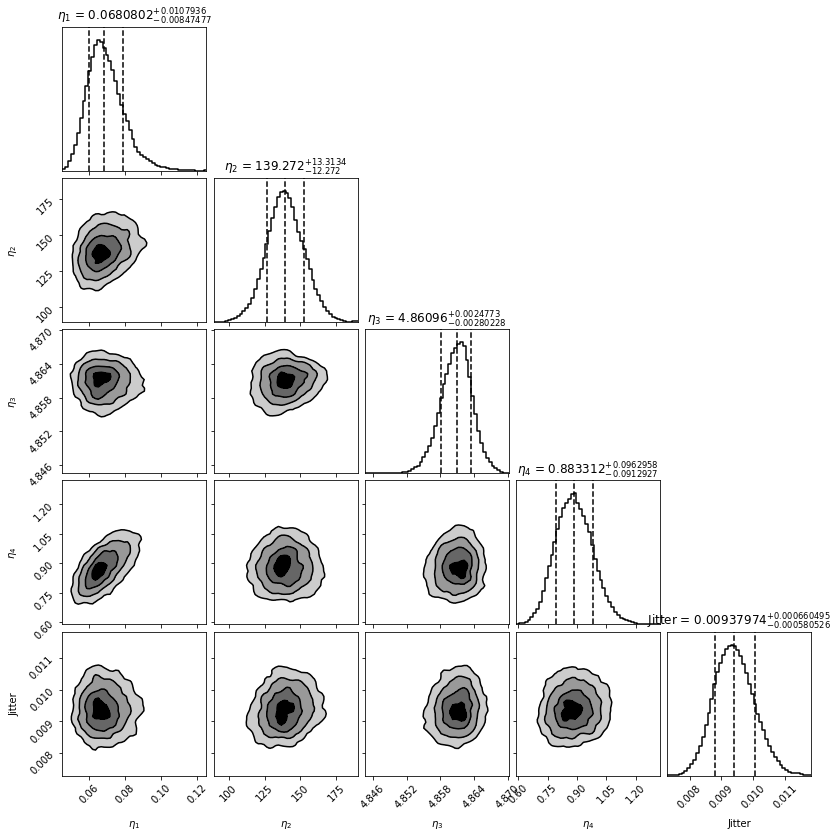

In [44]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

In [45]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[1]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[1],yerr = 1e-12 * np.identity(times[:-1].size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

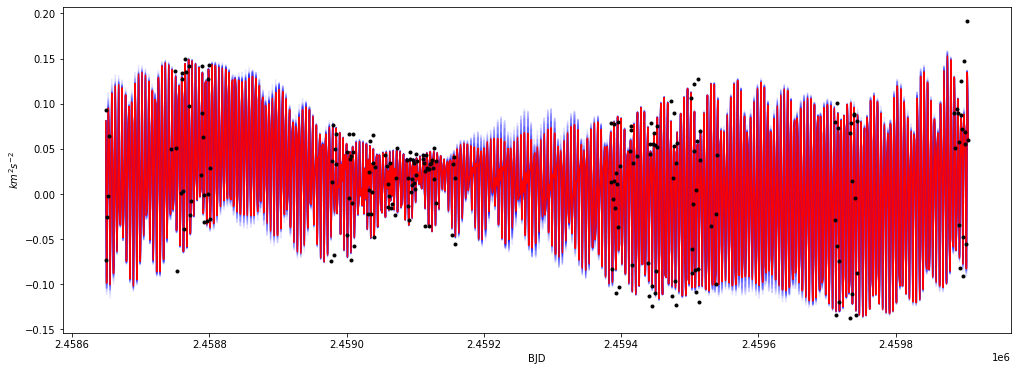

In [46]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times[:-1]), np.max(times[:-1]), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.plot(times[:-1], eigen2vectors[1],'k.')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

100%|██████████| 15/15 [01:35<00:00,  6.40s/it]


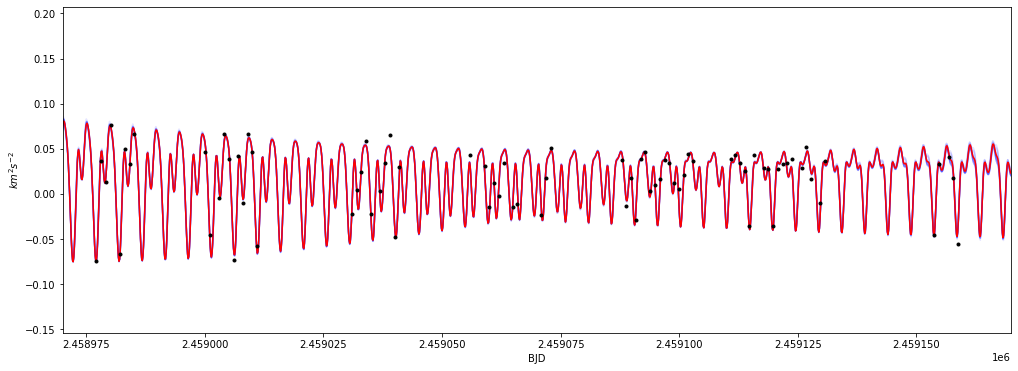

In [47]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times[:-1]), np.max(times[:-1]), 10000)

for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.plot(times[:-1], eigen2vectors[1],'k.')
plt.xlim([-30+2459000, 170+2459000])
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

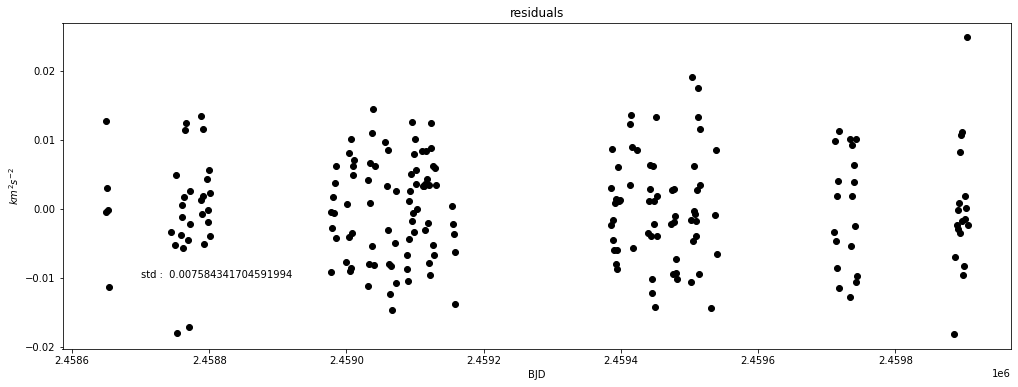

In [48]:
y_sample = Display(Hfit, times[:-1])

residuals = eigen2vectors[1] - y_sample
plt.figure(figsize=(17, 6))
plt.plot(times[:-1], residuals, 'ok')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, -0.01) )
plt.title('residuals')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

# Compares with Donati et al. (submitted)
## Load Data

In [4]:
B_table = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/AU_MIC/B.txt')


times_W, W1, dW1, W2, dW2, W3, dW3, W4, dW4, W5, dW5 = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/AU_MIC/AUMIC_DLW_PCA_units.rdb',
                   usecols=(0,1,2,3,4,5,6,7,8,9,10),skiprows=2, dtype=str, unpack=True)

times_W = np.array(times_W.astype(float))
W1 = np.array(W1.astype(float))
W2 = np.array(W2.astype(float))
W3 = np.array(W3.astype(float))
W4 = np.array(W4.astype(float))
W5 = np.array(W5.astype(float))
dW1 = np.array(dW1.astype(float))
dW2 = np.array(dW2.astype(float))
dW3 = np.array(dW3.astype(float))
dW4 = np.array(dW4.astype(float))
dW5 = np.array(dW5.astype(float))


times_pca = times[:-1] - 2459000
times_B = B_table[:,0]
B = B_table[:,1]
dB = B_table[:,2]

## Magnetic Field B

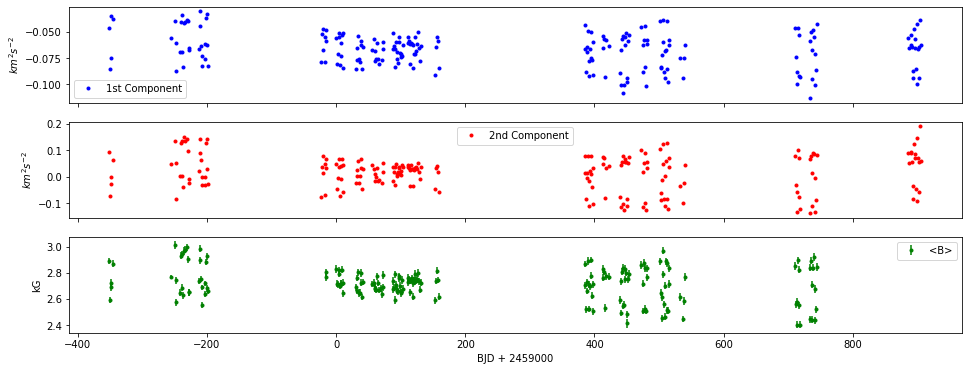

In [5]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(311)
plt.plot(times_pca, eigen2vectors[0], 'b.', label='1st Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(times_pca, eigen2vectors[1], 'r.', label='2nd Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
# make these tick labels invisible
plt.tick_params('x', labelbottom=False)

# share x and y
ax3 = plt.subplot(313, sharex=ax1)
plt.errorbar(times_B, B, yerr=dB, fmt='.g', label='<B>')
plt.xlabel('BJD + 2459000')
plt.ylabel('kG')
plt.legend()
plt.show()


Peak frequency = 
4.872610970182465


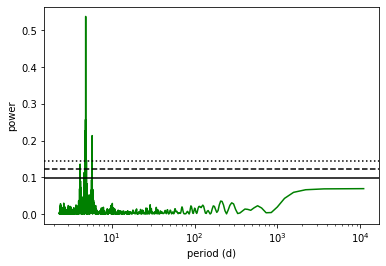

In [32]:
frequency, power = LombScargle(times_B, B).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'g')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times_B, B)

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

###  B GP

In [33]:
print(2*(np.max(B)- np.min(B)))
print(np.std(B))
print(10*(np.max(times_B)-np.min(times_B)))

1.2224000000000004
0.12771711650555842
10948.75685


In [16]:
#Priors
n_eta1 = ModifiedLogUniform(0.12, 1.2)
n_eta2 = stats.loguniform(1, 11000)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.12, 1.2)

In [17]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(B))
    gpOBJ = process.GP(kernel,mean,times_B,B, yerr = dB)
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [18]:
ndim = priors().size 
nwalkers = 2*ndim

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [04:54<00:00, 33.94it/s]


State([[1.94936633e-01 1.57101697e+02 4.86680430e+00 1.67354051e+00
  1.00230961e-03]
 [2.06816312e-01 1.68683300e+02 4.86055029e+00 1.45265357e+00
  9.06060126e-03]
 [1.41501910e-01 1.70390144e+02 4.85972211e+00 1.13654383e+00
  5.11146676e-03]
 [1.45012847e-01 1.53048276e+02 4.86196122e+00 1.05010444e+00
  1.48870213e-03]
 [1.15409155e-01 1.28596887e+02 4.86272729e+00 9.80526770e-01
  1.43063711e-02]
 [1.49051355e-01 1.53478643e+02 4.87118843e+00 1.41395856e+00
  1.05544456e-02]
 [1.53298987e-01 1.39826601e+02 4.85141238e+00 1.27590770e+00
  9.66071046e-03]
 [1.58139085e-01 2.20289217e+02 4.86187465e+00 1.27971647e+00
  1.26306788e-03]
 [1.67763658e-01 1.31399772e+02 4.85902127e+00 1.21942680e+00
  1.00638669e-02]
 [1.97172451e-01 1.67842061e+02 4.86642760e+00 1.37129274e+00
  3.50288487e-03]], log_prob=[326.69970249 326.9647178  328.00132825 327.17147546 324.2653652
 324.4054568  326.77417912 325.75257687 325.82111878 326.72045607], blobs=None, random_state=('MT19937', array([167563

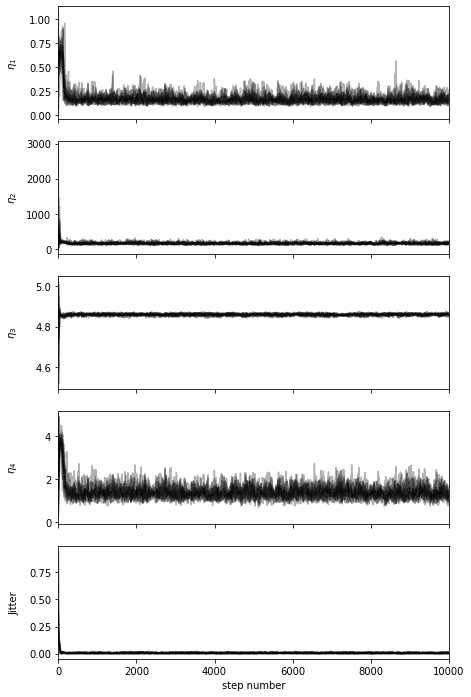

In [19]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

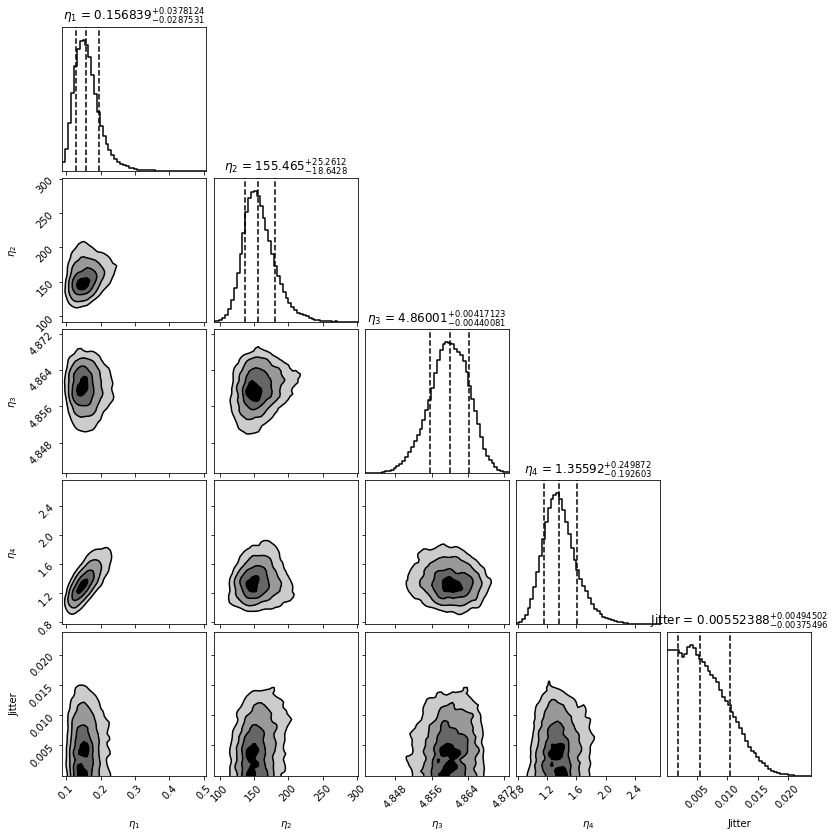

In [20]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

#### On retrouve l'exact même résultat que Donati et al. (Submitted) ! 

In [21]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(B))
    gpOBJ = process.GP(kernel,mean,times_B,B,yerr = dB)
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

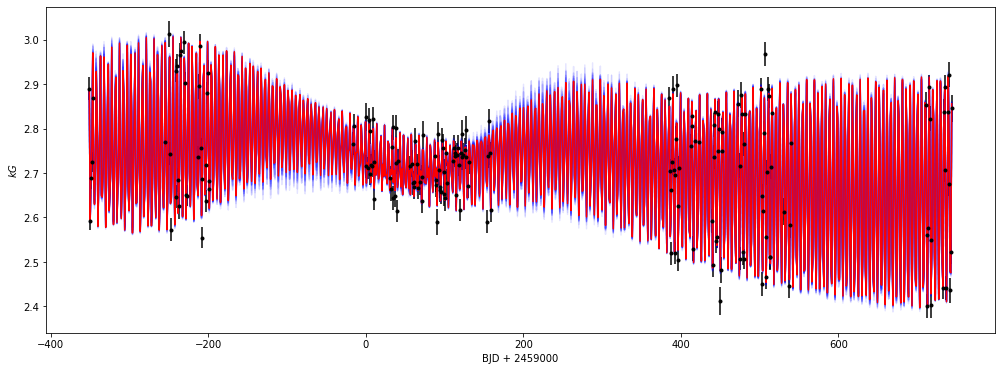

In [22]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(times_B[0], times_B[-1], 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_B, B, yerr=dB, fmt='k.')
plt.xlabel('BJD + 2459000')
plt.ylabel('$kG$')
plt.show()

100%|██████████| 15/15 [01:21<00:00,  5.46s/it]


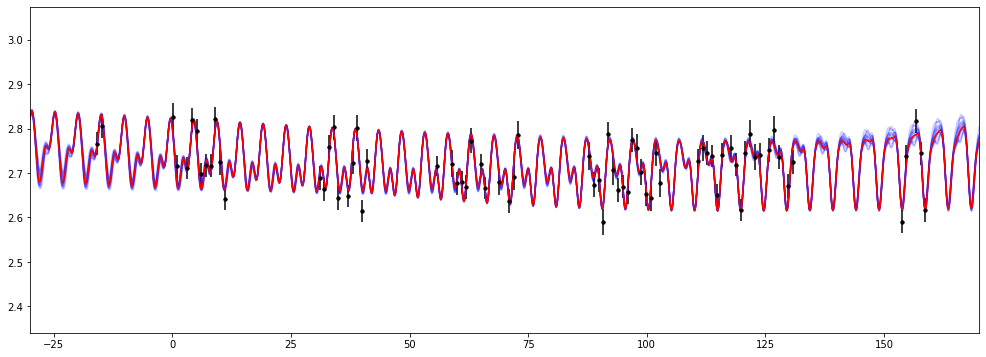

In [23]:
plt.figure(figsize=(17, 6))

plt.plot(times_B, B,'k.')
tplot = np.linspace(np.min(times_B), np.max(times_B), 10000)
 
for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_B, B, yerr=dB, fmt='k.')
plt.xlim([-30,170])
plt.show()

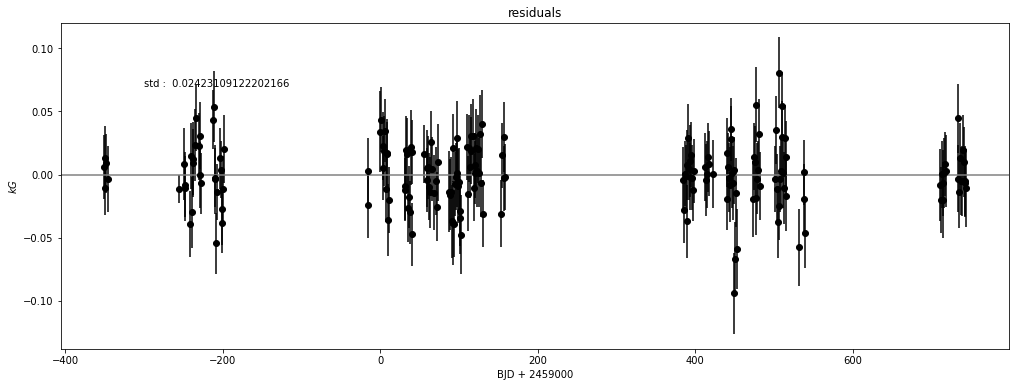

In [24]:
y_sample = Display(Hfit, times_B)

residuals = B - y_sample
plt.figure(figsize=(17, 6))
plt.errorbar(times_B, residuals, yerr=dB, fmt='ok')
plt.annotate( "std :  " + str(np.std(residuals)), (-300, 0.07) )
plt.axhline(y=0, c='grey')
plt.title('residuals')
plt.xlabel('BJD + 2459000')
plt.ylabel('$kG$')
plt.show()

### Correlation Coef

In [34]:
import pandas as pd


df1 = pd.DataFrame(dict(x=eigen2vectors[0]))
df2 = pd.DataFrame(dict(x=eigen2vectors[1]))

CORR_VALS = np.array(B)
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df1['correlation'] = df1.rolling(window=len(CORR_VALS)).apply(get_correlation)
df2['correlation'] = df2.rolling(window=len(CORR_VALS)).apply(get_correlation)


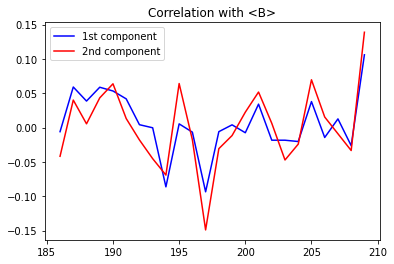

In [38]:
plt.plot(df1['correlation'].values, 'b', label='1st component')
plt.plot(df2['correlation'].values, 'r', label='2nd component')
plt.legend()
plt.title('Correlation with <B>')
plt.show()

## W1 

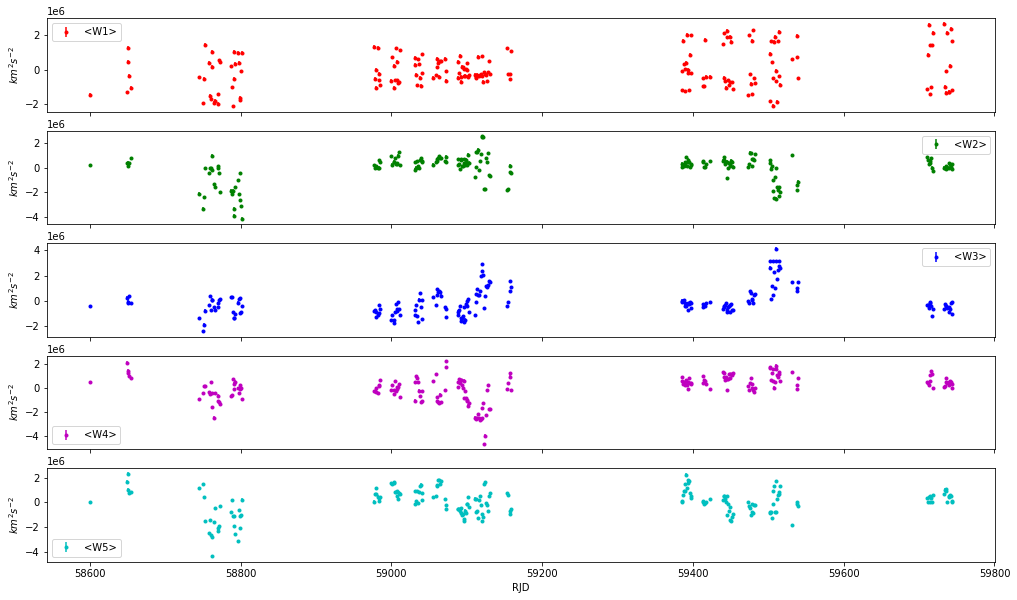

In [39]:
plt.figure(figsize=(17, 10))
ax1 = plt.subplot(511)
plt.errorbar(times_W, W1, yerr=dW1, fmt='.r', label='<W1>')
#plt.xlabel('BJD + 2459000')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)

# share x only
ax2 = plt.subplot(512, sharex=ax1)
plt.errorbar(times_W, W2, yerr=dW2, fmt='.g', label='<W2>')
#plt.xlabel('BJD + 2459000')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)

# share x only
ax2 = plt.subplot(513, sharex=ax1)
plt.errorbar(times_W, W3, yerr=dW3, fmt='.b', label='<W3>')
#plt.xlabel('BJD + 2459000')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)

# share x only
ax2 = plt.subplot(514, sharex=ax1)
plt.errorbar(times_W, W4, yerr=dW4, fmt='.m', label='<W4>')
#plt.xlabel('BJD + 2459000')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)

# share x and y
ax3 = plt.subplot(515, sharex=ax1)
plt.errorbar(times_W, W5, yerr=dW5, fmt='.c', label='<W5>')
plt.xlabel('RJD')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.show()

In [43]:
BJDtoRJD = times_W[1] - np.min(times_pca)

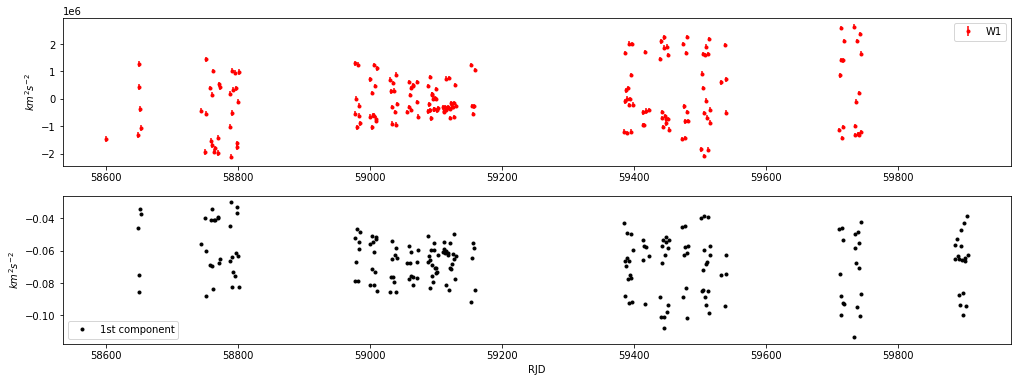

In [48]:
plt.figure(figsize=(17, 6))
ax1 = plt.subplot(211)
plt.errorbar(times_W, W1, yerr=dW1, fmt='.r', label='W1')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()

# share x and y
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(times_pca + BJDtoRJD, eigen2vectors[0], '.k', label='1st component')
plt.xlabel('RJD')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.show()


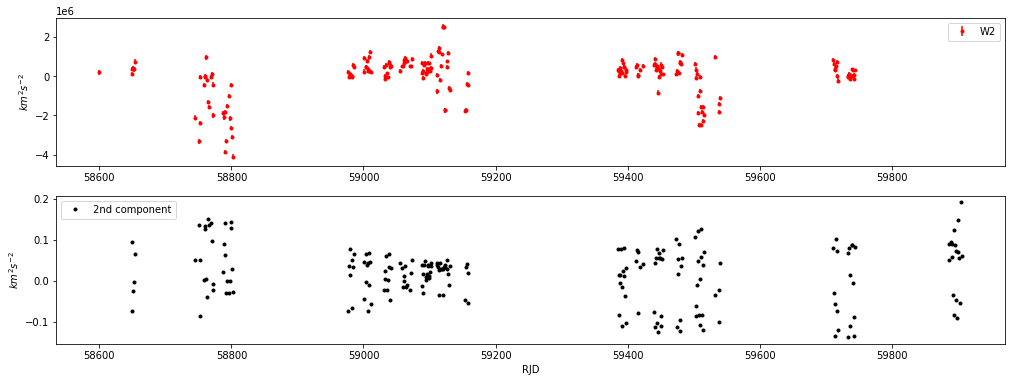

In [49]:
plt.figure(figsize=(17, 6))
ax1 = plt.subplot(211)
plt.errorbar(times_W, W2, yerr=dW2, fmt='.r', label='W2')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()

# share x and y
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(times_pca + BJDtoRJD, eigen2vectors[1], '.k', label='2nd component')
plt.xlabel('RJD')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.show()

### Correlation Coef

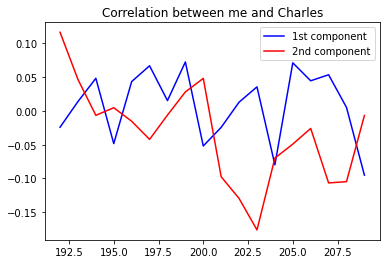

In [50]:
df1 = pd.DataFrame(dict(x=eigen2vectors[0]))

CORR_VALS = np.array(W1)
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df1['correlation'] = df1.rolling(window=len(CORR_VALS)).apply(get_correlation)

df2 = pd.DataFrame(dict(x=eigen2vectors[1]))

CORR_VALS = np.array(W2)
def get_correlation(vals):
    return stats.pearsonr(vals, CORR_VALS)[0]

df2['correlation'] = df2.rolling(window=len(CORR_VALS)).apply(get_correlation)

plt.plot(df1['correlation'].values, 'b', label='1st component')
plt.plot(df2['correlation'].values, 'r', label='2nd component')
plt.legend()
plt.title('Correlation between me and Charles')
plt.show()


### GP Charles
#### First component

In [56]:
print(2*(np.max(W1)- np.min(W1)))
print(np.std(W1))
print(10*(np.max(times_W)-np.min(times_W)))

9488407.474691853
1079723.4905268278
11438.773512459593


In [44]:
#Priors
n_eta1 = ModifiedLogUniform(900000, 2500000)
n_eta2 = stats.loguniform(1, 1255)
n_eta3 = stats.norm(loc=4.865, scale=0.05)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(1, 1000000)

def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(W1))
    gpOBJ = process.GP(kernel,mean,times_W,W1, yerr = dW1)
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

ndim = priors().size 
nwalkers = 2*ndim

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [05:11<00:00, 32.11it/s]


State([[1.04364666e+06 1.42452800e+02 4.86151908e+00 9.77095484e-01
  1.23737378e+05]
 [1.01785392e+06 1.12255637e+02 4.86140599e+00 8.65625575e-01
  9.65426733e+04]
 [1.11051898e+06 1.40848845e+02 4.85442446e+00 7.97898345e-01
  1.08570421e+05]
 [1.14873714e+06 1.30847318e+02 4.85298540e+00 9.19057027e-01
  1.05048778e+05]
 [8.70001924e+05 1.38255490e+02 4.86102056e+00 8.15066350e-01
  9.00865339e+04]
 [1.26569316e+06 1.45860368e+02 4.85670767e+00 9.82673620e-01
  9.75735963e+04]
 [9.67424689e+05 1.62608015e+02 4.85880921e+00 8.27038838e-01
  1.07355386e+05]
 [1.22409250e+06 1.33104587e+02 4.85783192e+00 9.05745370e-01
  1.06258711e+05]
 [9.22870974e+05 1.45893395e+02 4.86106884e+00 8.53883848e-01
  1.00199844e+05]
 [1.11410519e+06 1.29100556e+02 4.86898993e+00 8.92865695e-01
  8.85825317e+04]], log_prob=[-2710.62263323 -2710.21693997 -2709.58626202 -2710.21794491
 -2708.27485964 -2708.71788839 -2708.02248739 -2708.93495727
 -2707.64876703 -2713.54199359], blobs=None, random_state=('M

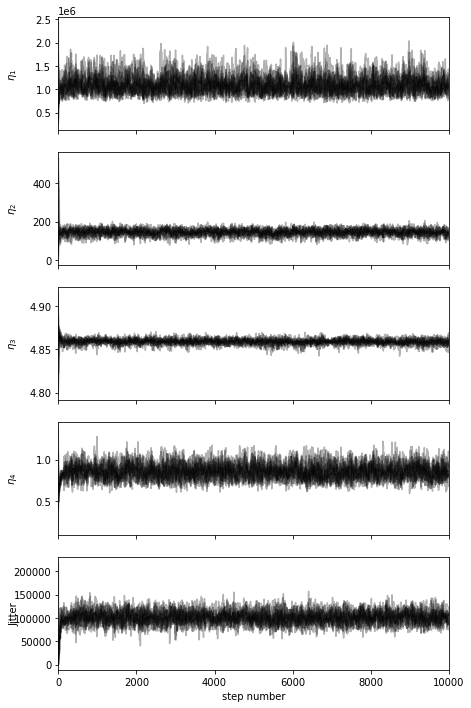

In [45]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

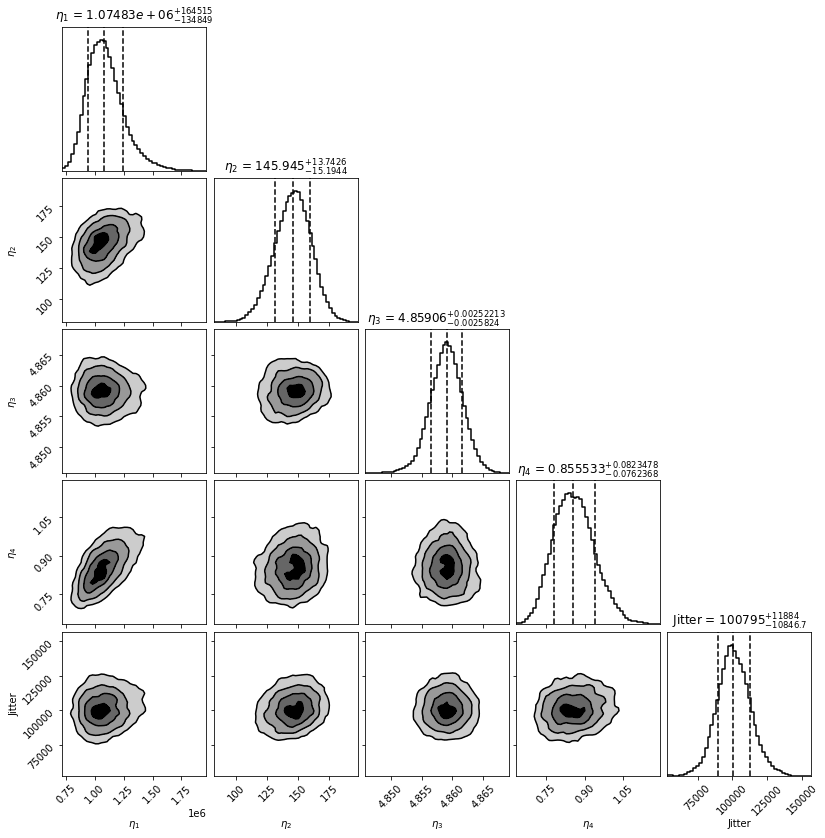

In [46]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

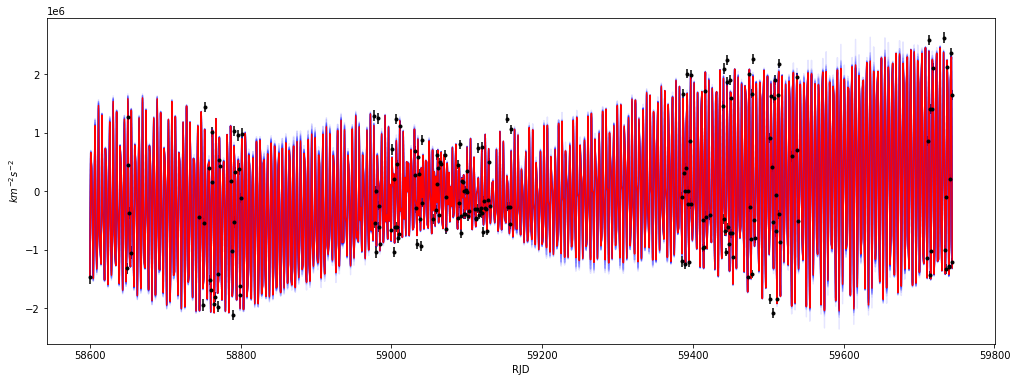

In [47]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(W1))
    gpOBJ = process.GP(kernel,mean,times_W, W1,yerr = dW1)
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

plt.figure(figsize=(17, 6))
tplot = np.linspace(times_W[0], times_W[-1], 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_W, W1, yerr=dW1, fmt='k.')
plt.xlabel('RJD')
plt.ylabel('$km^{-2}s^{-2}$')
plt.show()

100%|██████████| 15/15 [01:28<00:00,  5.87s/it]


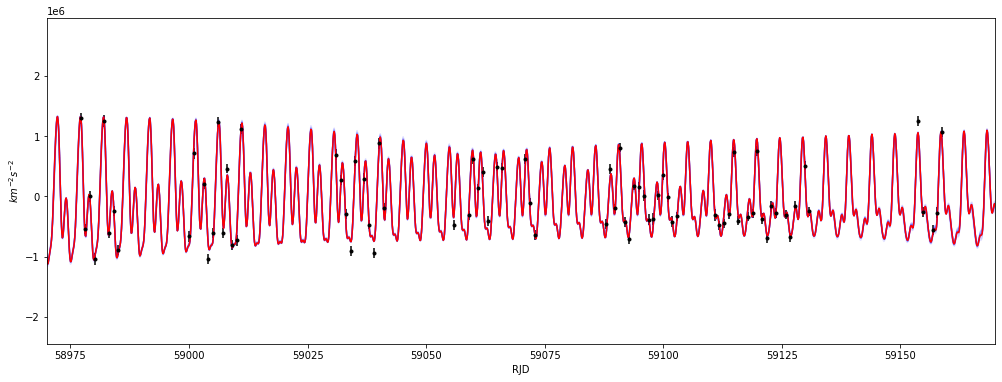

In [49]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(times_W[0], times_W[-1], 10000)

for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_W, W1, yerr=dW1, fmt='k.')
plt.xlabel('RJD')
plt.ylabel('$km^{-2}s^{-2}$')
plt.xlim([-30 + BJDtoRJD, 170 + BJDtoRJD])
plt.show()